# Gaussian process regression for arterial tissue

In [12]:
import numpy as np
import GPy
from IPython.display import display
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as mse
import math 
import pickle
import pandas as pd
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from pyDOE import *
plt.style.use("seaborn-darkgrid")

In [13]:
## The ground-truth data
strain_fe_media = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35]
stress_fe_media = [0, 0.00169707, 0.00336693, 0.00501758, 0.00665913, 0.00830489, 0.00997227, 0.0116837, 0.0134675, 0.0153589, 0.0174013, 0.0196476, 0.0221622, 0.0250236, 0.028327, 0.0321884, 0.0367485, 0.0421783, 0.0486846, 0.0565163, 0.0659717, 0.0774054, 0.0912357, 0.107951, 0.128119, 0.152385, 0.181485, 0.216236, 0.257543, 0.306386, 0.363809, 0.430904, 0.508782, 0.598541, 0.701216, 0.817721]
  
stress_fe_media  = np.array(stress_fe_media)[list(np.arange(0, len(stress_fe_media), 2))]
strain_fe_media  = np.array(strain_fe_media)[list(np.arange(0, len(strain_fe_media), 2))]

sampled_coeffs = pd.read_csv(r'coefficients_18.csv')
stress_values = pd.read_csv(r'stress_values_18.csv')

sampled_coeffs = sampled_coeffs.to_numpy()
stress_values = stress_values.to_numpy()


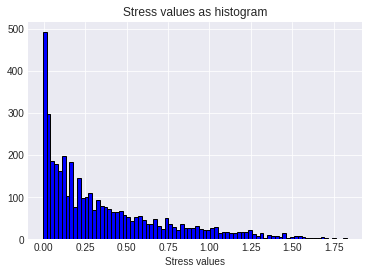

In [15]:
plt.grid()
plt.hist(stress_values.flatten(), bins = int(80), color = 'blue', edgecolor = 'black')
plt.xlabel("Stress values")
plt.title("Stress values as histogram")
plt.grid()
plt.show()

In [3]:
## Sample randomly from parameter space:
def sampling_ps_random(par_space, N_samples):  
    indices = np.random.choice(par_space.shape[0], N_samples)  # par_space.shape[0] = p_length**p_numb
    return par_space[set(indices)]


## Sample indices of parameters by latin hypercube sampling
def sampling_ind_lhs(dimension, N_samples):  
    indices = (lhs(N_samples, samples = 1) * dimension).squeeze()
    indices = [int(i) for i in indices]
    return list(set(indices))

def create_parameters_space(coefficient_sets, stress_values, strain_values):
    '''
    Create spaces of parameters and stress values.
    
    Returns
    -------
    parameters_space: array_like
        [strain value, c1, ...c6]
        
    stress_space: array_like
        AB model stress response for each set of parameters 
    
    '''
    parameters_space = []
    stress_space = []
    for i in range(coefficient_sets.shape[0]):
        for j in range(len(strain_values)):
            parameters_space.append(np.insert(coefficient_sets[i],0,strain_values[j]))
            stress_space.append([stress_values[i][j]])
            
    return np.array(parameters_space), np.array(stress_space)


def create_coefficients_set(coefficient_sets, strain_values):
    ''' 
    Create coefficients set : [strain value, c1, ...c6] 
    '''
    parameter_space = []
    for j in range(len(strain_values)):
        parameter_space.append(np.insert(coefficient_sets,0,strain_values[j])) 
    return np.array(parameter_space)

# GP Model

In [25]:
parameter_space, stress_space = create_parameters_space(sampled_coeffs, stress_values, strain_fe_media)
parameter_space.shape

(4122, 7)

In [28]:
## Create parameters and stress values spaces 
parameters_space, stress_space = create_parameters_space(sampled_coeffs, stress_values, strain_fe_media)

## Sample training data
sampled_indices = sampling_ind_lhs(parameters_space.shape[0],3500)

X_train = parameter_space[sampled_indices]
y_train = stress_space[sampled_indices]

## Define kernel
ker = GPy.kern.Matern52(input_dim = 7, ARD=True)

## Define GP model
model = GPy.models.GPRegression(X_train, y_train, ker)
model.constrain_positive('')

## Optimize 
model.optimize(messages=True, max_f_eval = 3000)

 /home/salome/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


In [4]:
# ## Save the model
# with open('GPy_model_media_18.pkl', 'wb') as file:
#     pickle.dump(model, file)

## Load the model
with open('GPy_model_media_18.pkl', 'rb') as file:
    model = pickle.load(file)

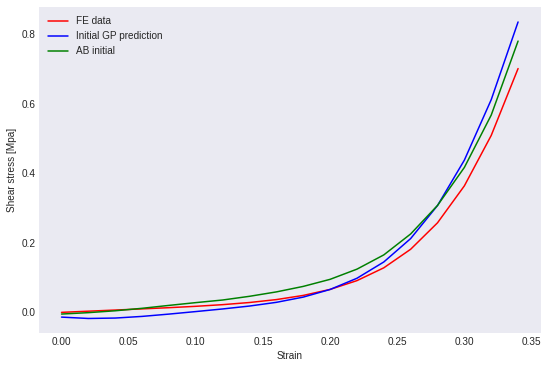

In [47]:
'''
Test in experimental data 
'''
initial_coeffs = [0.3,0,0,0,0,1050]
calibrated_coeffs = np.array([0.162, 0.204, 0.957, 0.868, 0.962, 911.313])


AB_initial = [-0.00484737,-0.00084348,0.00454305,0.0116706,0.0200137,0.0280109,0.0355181,0.0461782,0.0588343,0.07464,0.0949704,0.124247,0.165261,0.225507,0.307474,0.416782,0.567361,0.780216]
AB_new = [-0.00573361,-0.00269623,0.000366507,0.00547262,0.0103093,0.0161147,0.0224274,0.0288139,0.0384203,0.0515264,0.0686126,0.0963543,0.123549,0.16821,0.235032,0.35073,0.49698,0.686511]

initial_set = create_coefficients_set(initial_coeffs, strain_fe_media)
calibrated_set = create_coefficients_set(calibrated_coeffs, strain_fe_media)

simY_initial, simMse_initial = model.predict(initial_set)
simY_calibrated, simMse_calibrated = model.predict(calibrated_set)

fig, ax = plt.subplots(figsize=[9, 6])
plt.plot(strain_fe_media, stress_fe_media,  label ="FE data" ,color = "red")
plt.plot(strain_fe_media, simY_FE,label = "Initial GP prediction" ,color = "blue")#, rmse = %s"%rmse_gp)
plt.plot(strain_fe_media, AB_media,color = "green", label = "AB initial")
ax.grid()
plt.xlabel("Strain")
plt.ylabel("Shear stress [Mpa]")
plt.legend()
plt.show()


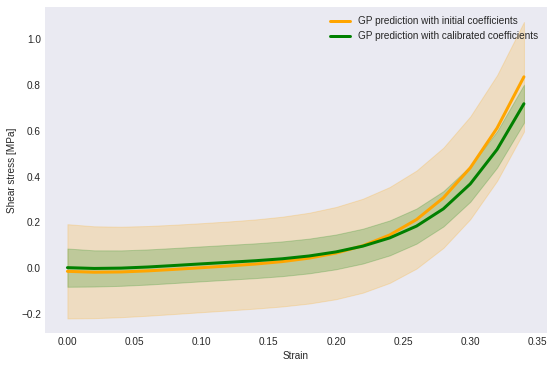

In [46]:
'''
Comparision to GP prediction with calibrated coefficients 
'''

calibrated_set = create_coefficients_set(calibrated_coeffs, strain_fe_media)

simY_initial, simMse_initial = model.predict(initial_set)
dyfit_initial = 2 * np.sqrt(simMse_initial)  # 2*sigma ~ 95% confidence interval

simY_calibrated, simMse_calibrated = model.predict(calibrated_set)
dyfit_cal = 2 * np.sqrt(simMse_calibrated)  # 2*sigma ~ 95% confidence interval

fig, ax = plt.subplots(figsize=[9, 6])
plt.plot(strain_fe_media, simY_initial, color = "orange",linewidth = 3,  label = "GP prediction with initial coefficients")
plt.fill_between(strain_fe_media, simY_initial.squeeze() - dyfit_initial.squeeze(), simY_initial.squeeze() + dyfit_initial.squeeze(),
                 color='orange', alpha=0.2)

plt.plot(strain_fe_media, simY_calibrated, color = "green",linewidth = 3, label = "GP prediction with calibrated coefficients")
plt.fill_between(strain_fe_media, simY_calibrated.squeeze() - dyfit_cal.squeeze(), simY_calibrated.squeeze() + dyfit_cal.squeeze(),
                 color='green', alpha=0.2)

plt.xlabel("Strain")
plt.ylabel("Shear stress [MPa]")
plt.legend()
plt.grid()
plt.show()


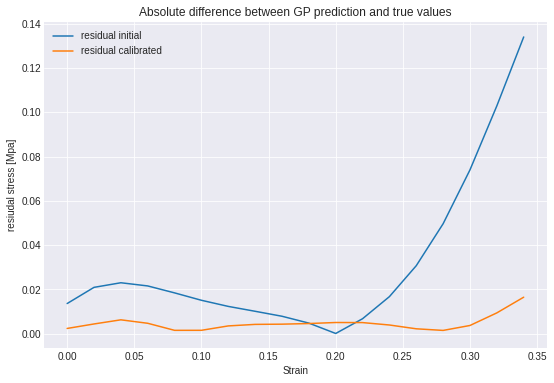

In [45]:
fig, ax = plt.subplots(figsize=[9, 6])
plt.plot(strain_fe_media,[(abs(stress_fe_media[i] - simY_FE[i])[0]) for i in range(18)], label = 'residual initial')
plt.plot(strain_fe_media,[(abs(stress_fe_media[i] - simY_calibrated[i])[0]) for i in range(18)], label = 'residual calibrated')
plt.legend()
plt.title("Absolute difference between GP prediction and true values" )
plt.xlabel("Strain")
plt.ylabel("resiudal stress [Mpa]")
plt.show()

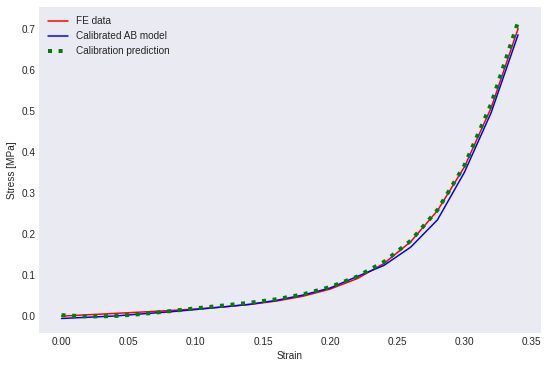

In [48]:

fig, ax = plt.subplots(figsize=[9, 6])
ax.plot(strain_fe_media, stress_fe_media, label ="FE data", color = "red" )
ax.plot(strain_fe_media, AB_calibrated, label ="Calibrated AB model", color = "blue" )
plt.plot(strain_fe_media,  simY_calibrated, ":", linewidth = "4", color = "green",label = "Calibration prediction")
plt.xlabel("Strain")
plt.ylabel("Stress [MPa]")
plt.grid()
plt.legend()
plt.show()

In [9]:
'''
Test in unknown data points
'''

new_indices = [ind for ind in np.arange(parameter_space.shape[0]) if ind not in sampled_indices]
testX = parameter_space[new_indices]
testY = stress_space[new_indices]
simY, simMse = model.predict(testX)  # Mean and variance of prediction
rmse = np.sqrt(mse(testY, simY))  # Root mean squared error

print("RMSE: {}".format(rmse))

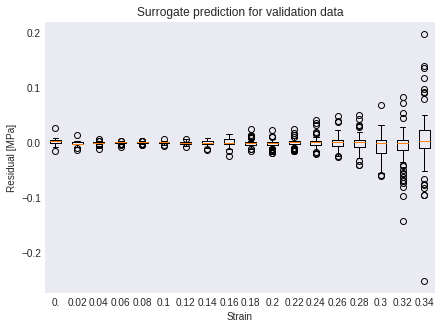

In [73]:
'''
Plotting difference between GP predicted and true stress values per strain values 
'''
total_array = []
for strain_value in strain_fe_media:    
    indices = np.where(testX[:, 0] == strain_value)
    total_array.append((testY[indices] - simY[indices]).squeeze())

plt.figure(figsize=(7,5))  
plt.boxplot(total_array)
plt.xticks([1, 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18], ["0.","0.02", "0.04", "0.06", "0.08", "0.1" , "0.12", "0.14", "0.16",
                                        "0.18", "0.2" ,"0.22", "0.24", "0.26", "0.28", "0.3" , "0.32", "0.34"])

plt.xlabel("Strain")
plt.ylabel("Residual [MPa]")
plt.title("Surrogate prediction for validation data")
plt.grid()
plt.show()

# Sensitivity Analysis

In [73]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

problem = {
    'num_vars': 6,
    'names': ['c1', 'c2', 'c3', 'c4', 'c5', 'c6'],
    'bounds': [[0, 0.021],
               [0, 0.7951199200000003],
               [0, 2.3385880000000006],
               [0, 6.878200000000002],
               [0, 60.0],
               [0, 262.5]]
               
}

param_values = saltelli.sample(problem, 2000)

In [74]:
'''
For each strain values collect predictions
'''
YY = []
for st in range(len(strain_fe_adventitia)):  
    Y = np.zeros([param_values.shape[0]])
    for i, par in enumerate(param_values):
        P = np.insert(par,0,strain_fe_adventitia[st])
        Y[i] = model.predict(np.array([P]))[0]
    YY.append(Y)

    

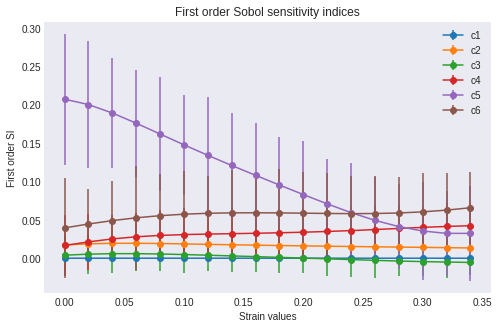

In [75]:
# example data
x = strain_fe_adventitia
plt.figure(figsize=(8,5))
for j in range(6):
    y = np.array([sobol.analyze(problem, YY[i])['S1'][j] for i in range(18) ])
    error = np.array([sobol.analyze(problem, YY[i])['S1_conf'][j] for i in range(18) ])
    plt.errorbar(x, y, yerr=error, fmt='-o', label = "c%s"%(j+1))
plt.legend()
plt.xlabel("Strain values")
plt.ylabel("First order SI")
plt.title("First order Sobol sensitivity indices")
plt.grid()
plt.show()


In [74]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13})

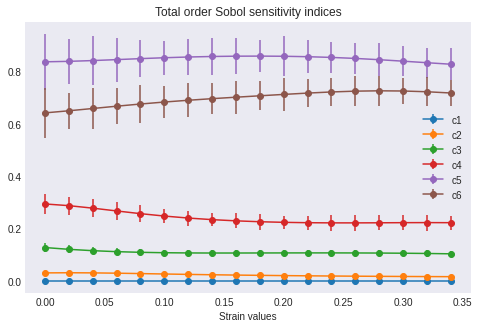

In [77]:
# example data
x = strain_fe_adventitia

plt.figure(figsize=(8,5))
for j in range(6):
    y = np.array([sobol.analyze(problem, YY[i])['ST'][j] for i in range(18) ])
    error = np.array([sobol.analyze(problem, YY[i])['ST_conf'][j] for i in range(18) ])
    plt.errorbar(x, y, yerr=error, fmt='-o', label = "c%s"%(j+1))
plt.legend()
plt.xlabel("Strain values")
plt.title("Total order Sobol sensitivity indices")
plt.grid()
plt.show()


# Active Learning

In [170]:

'''
acquisition function for Active Learning
'''

def surrogate(model, X):
    return model.predict(X)


def acquisition_func(X, Xsamples, model):
    # calculate the best surrogate score found so far 
    yhat, yhat_std = surrogate(model, X)
    best = max(yhat)
    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)
    mu = mu[:, 0]
    # Probability of improvement
    probs = norm.cdf((mu - best) / (std[:, 0]+1E-9))
    return probs

# optimize the acquisition function:
def acquisition_optimize(X, par_space, N_samples, model):   # dim = (number of samples x number of parameters)
    # generate random samples 
    Xsamples = sampling_ps_random(par_space, N_samples)
    # calculate the acquisition function for each sample
    scores = acquisition_func(X, Xsamples, model)
    # index of the largest scores
    ix = np.argmax(scores)
    res = np.array(Xsamples[ix]).reshape(1, par_space.shape[1])
    return res, ix

X = parameter_space[new_indices]
y = stress_space[new_indices]

# perform the optimization process
for i in range(500):
    # select the next point to sample
    
    new_x, ind = acquisition_optimize(X, parameter_space, 50 , model)

    # sample the point
    real_new_y = y[ind]
    
    # add the data to the dataset
    X = np.vstack((X, new_x))
    y = np.vstack((y, real_new_y))
    # update the model
    model.optimize(messages=False, max_iters=1000)

In [168]:
'''
Test in unknown data points
'''

new_indices = [ind for ind in np.arange(1800) if ind not in sampled_indices]
testX = parameter_space[new_indices]
testY = stress_space[new_indices]
simY, simMse = model.predict(testX)  # Mean and variance of prediction
rmse = np.sqrt(mse(testY, simY))  # Root mean squared error
print("RMSE: {}".format(rmse))



RMSE: 0.3285978204840542
